In [1]:
# read the hotel reservation file
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.express as px
import numpy as np
import arules
import arules as ar
from arules.utils import five_quantile_based_bins, top_bottom_10, top_5_variant_variables, top_10_variant_variables, specified_list_of_variables, equal_value_range_bins_10


hotel = pd.read_csv('Hotel Reservations.csv')

In [3]:
hotel['lead_time'] = hotel['lead_time'].astype('float64')

In [3]:
len(hotel['lead_time'].value_counts())

352

In [3]:

rules, supp_dict = ar.create_association_rules(hotel,max_cols=3,binning_method=five_quantile_based_bins, min_supp=0.01)

In [4]:
rules_2, supp_dict = ar.create_association_rules(hotel,max_cols=2,binning_method=five_quantile_based_bins, min_supp=0.01)

True
352
36275


D:\ProgramData\Anaconda3\envs\DataMining\lib\site-packages\arules\utils\binning.py:88: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  attached_series = binned_series.append(na_series).reindex(series.index)
D:\ProgramData\Anaconda3\envs\DataMining\lib\site-packages\arules\utils\binning.py:88: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  attached_series = binned_series.append(na_series).reindex(series.index)


Calculating all relevant supports
100%|██████████| 190/190 [00:02<00:00, 76.80it/s] 

Calculating all feature level rules per variable level rule
100%|██████████| 342/342 [00:01<00:00, 234.33it/s]
Overall # of Rules:  3470


In [8]:
rules_2[rules_2['confidence'] > 0.5]

,antecedent,consequent,rule print,ant_count,con_count,rule_count,ant_supp,con_supp,rule_supp,confidence,lift,# of all records
0,{'room_type_reserved': 'Room_Type 6'},{'no_of_children': '2'},room_type_reserved=Room_Type 6 ==> no_of_children=2,966,1058,776,0.026630,0.029166,0.021392,0.8033,27.5427,36275
1,{'no_of_children': '2'},{'room_type_reserved': 'Room_Type 6'},no_of_children=2 ==> room_type_reserved=Room_Type 6,1058,966,776,0.029166,0.026630,0.021392,0.7335,27.5427,36275
2,{'repeated_guest': '1'},{'market_segment_type': 'Corporate'},repeated_guest=1 ==> market_segment_type=Corporate,930,2017,602,0.025637,0.055603,0.016595,0.6473,11.6417,36275
4,{'market_segment_type': 'Complementary'},{'avg_price_per_room': '[0.0 - 76.0]'},market_segment_type=Complementary ==> avg_price_per_room=[0.0 - 76.0],391,7291,388,0.010779,0.200992,0.010696,0.9923,4.9371,36275
6,{'room_type_reserved': 'Room_Type 6'},{'avg_price_per_room': '(129.0 - 540.0]'},room_type_reserved=Room_Type 6 ==> avg_price_per_room=(129.0 - 540.0],966,7109,926,0.026630,0.195975,0.025527,0.9586,4.8914,36275
...,...,...,...,...,...,...,...,...,...,...,...,...
3310,{'room_type_reserved': 'Room_Type 2'},{'no_of_children': '0'},room_type_reserved=Room_Type 2 ==> no_of_children=0,692,33577,482,0.019076,0.925624,0.013287,0.6965,0.7525,36275
3314,{'type_of_meal_plan': 'Meal Plan 2'},{'arrival_year': '2018'},type_of_meal_plan=Meal Plan 2 ==> arrival_year=2018,3305,29761,2031,0.091110,0.820427,0.055989,0.6145,0.7490,36275
3330,{'market_segment_type': 'Corporate'},{'no_of_previous_bookings_not_canceled': '0'},market_segment_type=Corporate ==> no_of_previous_bookings_not_canceled=0,2017,35463,1435,0.055603,0.977615,0.039559,0.7115,0.7277,36275
3338,{'market_segment_type': 'Corporate'},{'repeated_guest': '0'},market_segment_type=Corporate ==> repeated_guest=0,2017,35345,1415,0.055603,0.974363,0.039008,0.7015,0.7200,36275


lead_time


D:\ProgramData\Anaconda3\envs\DataMining\lib\site-packages\numpy\core\fromnumeric.py:3571: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


,rule print,ant_supp,con_supp,rule_supp,confidence,lift
5,lead_time=[0.0 - 11.0] ==> booking_status=Not_Canceled,0.200055,0.672364,0.178718,0.8933,1.3287
11,lead_time=(11.0 - 39.0] ==> booking_status=Not_Canceled,0.207471,0.672364,0.165100,0.7958,1.1835
16,lead_time=(39.0 - 80.0] ==> booking_status=Not_Canceled,0.196720,0.672364,0.145996,0.7422,1.1038
64,lead_time=(80.0 - 151.0] ==> booking_status=Not_Canceled,0.198704,0.672364,0.127994,0.6441,0.9580
90,lead_time=(151.0 - 443.0] ==> booking_status=Not_Canceled,0.197050,0.672364,0.054555,0.2769,0.4118


D:\ProgramData\Anaconda3\envs\DataMining\lib\site-packages\arules\association_rules.py:408: UserWarning: FixedFormatter should only be used together with FixedLocator
  labs_x = ['X'+ str(np.round(lab,1)) for lab in labs]


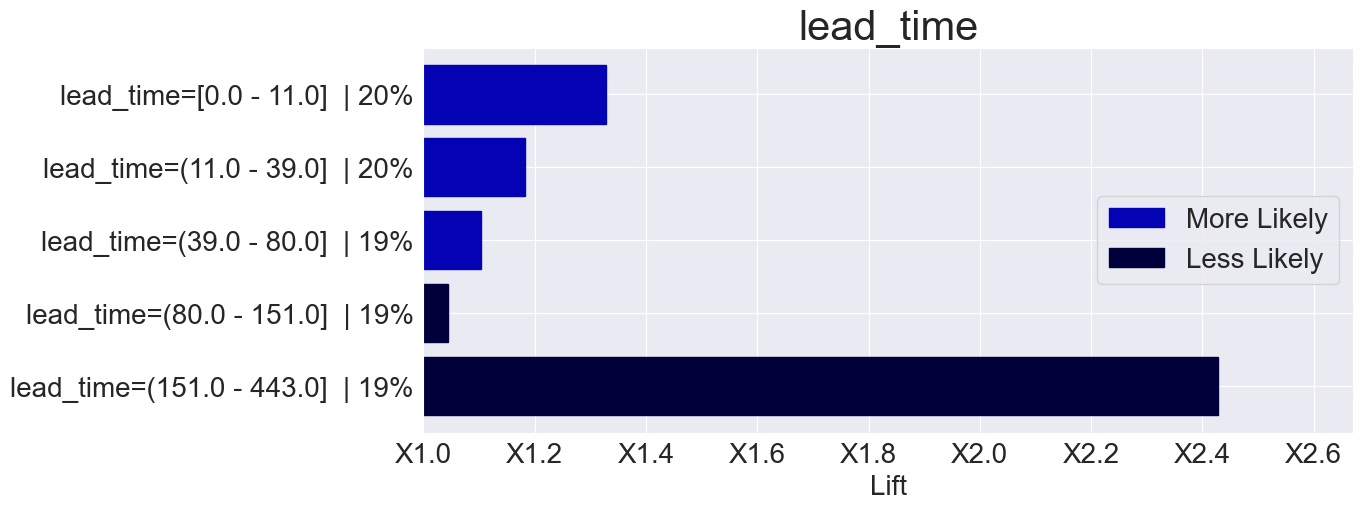

repeated_guest


,rule print,ant_supp,con_supp,rule_supp,confidence,lift
2,repeated_guest=1 ==> booking_status=Not_Canceled,0.025637,0.672364,0.025196,0.9828,1.4617
51,repeated_guest=0 ==> booking_status=Not_Canceled,0.974363,0.672364,0.647167,0.6642,0.9879


D:\ProgramData\Anaconda3\envs\DataMining\lib\site-packages\arules\association_rules.py:408: UserWarning: FixedFormatter should only be used together with FixedLocator
  labs_x = ['X'+ str(np.round(lab,1)) for lab in labs]


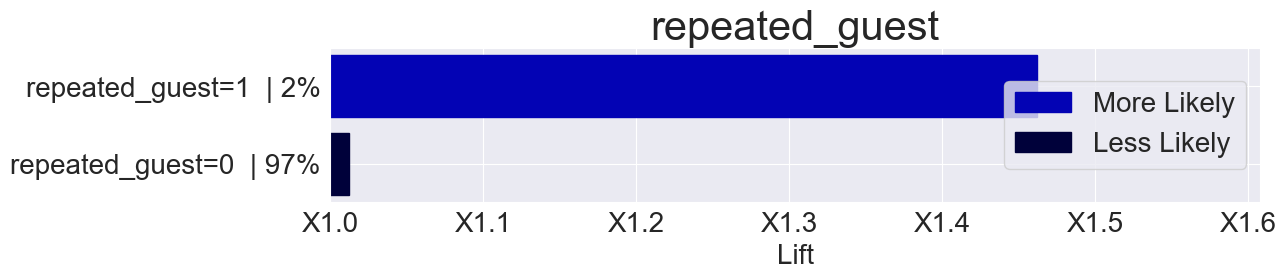

no_of_special_requests


,rule print,ant_supp,con_supp,rule_supp,confidence,lift
1,no_of_special_requests=3 ==> booking_status=Not_Canceled,0.018608,0.672364,0.018608,1.0000,1.4873
8,no_of_special_requests=2 ==> booking_status=Not_Canceled,0.120303,0.672364,0.102743,0.8540,1.2702
13,no_of_special_requests=1 ==> booking_status=Not_Canceled,0.313522,0.672364,0.239008,0.7623,1.1338
86,no_of_special_requests=0 ==> booking_status=Not_Canceled,0.545196,0.672364,0.309635,0.5679,0.8447


D:\ProgramData\Anaconda3\envs\DataMining\lib\site-packages\arules\association_rules.py:408: UserWarning: FixedFormatter should only be used together with FixedLocator
  labs_x = ['X'+ str(np.round(lab,1)) for lab in labs]


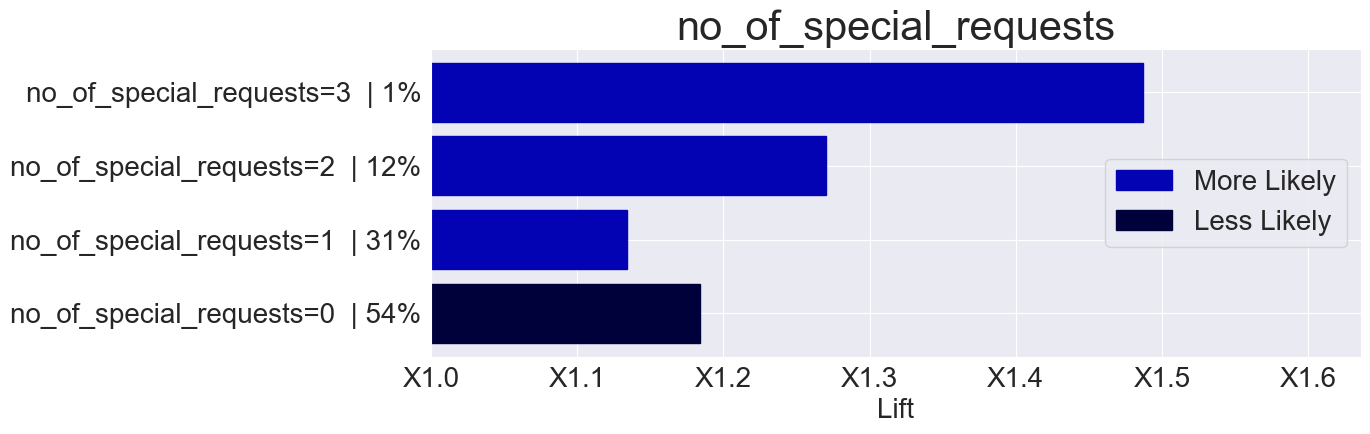

market_segment_type


,rule print,ant_supp,con_supp,rule_supp,confidence,lift
0,market_segment_type=Complementary ==> booking_status=Not_Canceled,0.010779,0.672364,0.010779,1.0000,1.4873
6,market_segment_type=Corporate ==> booking_status=Not_Canceled,0.055603,0.672364,0.049538,0.8909,1.3251
30,market_segment_type=Offline ==> booking_status=Not_Canceled,0.290227,0.672364,0.203308,0.7005,1.0419
70,market_segment_type=Online ==> booking_status=Not_Canceled,0.639945,0.672364,0.406313,0.6349,0.9443


D:\ProgramData\Anaconda3\envs\DataMining\lib\site-packages\arules\association_rules.py:408: UserWarning: FixedFormatter should only be used together with FixedLocator
  labs_x = ['X'+ str(np.round(lab,1)) for lab in labs]


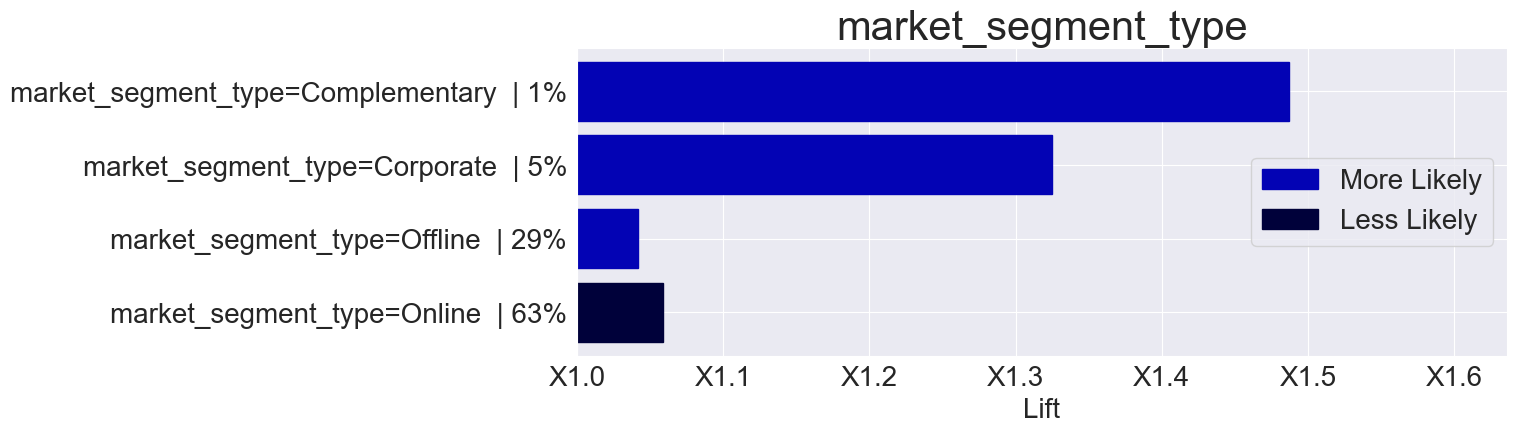

required_car_parking_space


,rule print,ant_supp,con_supp,rule_supp,confidence,lift
4,required_car_parking_space=1 ==> booking_status=Not_Canceled,0.030986,0.672364,0.027843,0.8986,1.3364
49,required_car_parking_space=0 ==> booking_status=Not_Canceled,0.969014,0.672364,0.644521,0.6651,0.9892


D:\ProgramData\Anaconda3\envs\DataMining\lib\site-packages\arules\association_rules.py:408: UserWarning: FixedFormatter should only be used together with FixedLocator
  labs_x = ['X'+ str(np.round(lab,1)) for lab in labs]


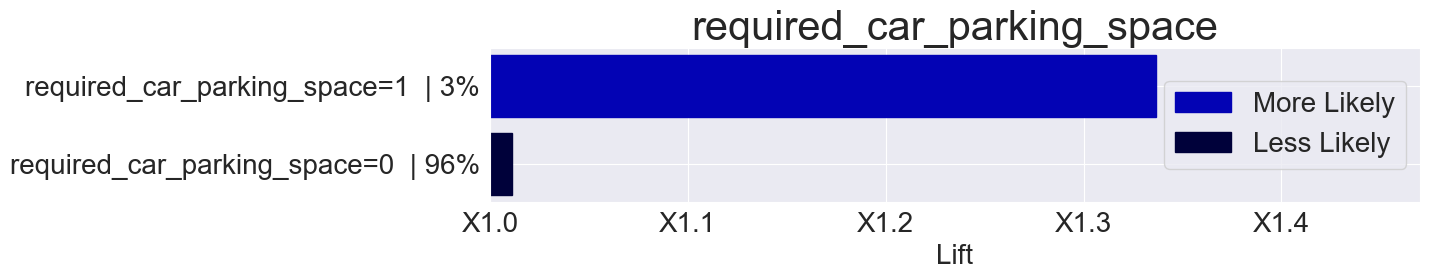

In [6]:
pd.options.display.max_colwidth = 100
ar.present_rules_per_consequent(rules_2,consequent={'booking_status':'Canceled', 'booking_status':'Not_Canceled'}, drop_dups=True, selection_function=top_5_variant_variables,
                                plot=True)

In [ ]:
del hotel[hotel.columns[0]]
hotel = hotel[1:]

In [7]:
hotel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          36275 non-null  int64  
 2   no_of_children                        36275 non-null  int64  
 3   no_of_weekend_nights                  36275 non-null  int64  
 4   no_of_week_nights                     36275 non-null  int64  
 5   type_of_meal_plan                     36275 non-null  object 
 6   required_car_parking_space            36275 non-null  int64  
 7   room_type_reserved                    36275 non-null  object 
 8   lead_time                             36275 non-null  int64  
 9   arrival_year                          36275 non-null  int64  
 10  arrival_month                         36275 non-null  int64  
 11  arrival_date   

In [ ]:
categorical_columns = [
    "type_of_meal_plan",
    "required_car_parking_space",
    "room_type_reserved",
    "market_segment_type",
    "repeated_guest",
    "booking_status"
]

hotel = hotel.drop(['Booking_ID'], axis=1)  

numerical_columns = hotel.columns.difference(categorical_columns)


In [111]:
#implement association rules for every column
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

def discretize(df, column, bins, labels):
    df[column] = pd.cut(df[column], bins=bins, labels=labels)

#discretize average price
bins = [i * 25 for i in range(24)]
labels =  ["P" + str(i * 25) + "-" + str((i+1) * 25) for i in range(23)]

hotel[16] = hotel[16].astype('float64')
discretize(hotel, 16, bins=bins, labels=labels)
hotel[16] = hotel[16].astype('object')

bins = [i * 25 for i in range(18)]
labels =  ["L" + str(i * 25) + "-" + str((i+1) * 25) for i in range(17)]
hotel[8] = hotel[8].astype('int64')
discretize(hotel, 8, bins=bins, labels=labels)
hotel[8] = hotel[8].astype('object')

col_abvr = ['AD_', 'CH_', 'WEN_', "WKN_", "", "PARK_", "", "", "", "MON_", "DATE_", "", "REP_", "PC_", "PNC_", "", "SPEC_", ""]
print(len(col_abvr))
print(hotel.shape[1])
for i in range(len(col_abvr)):
    hotel.iloc[:,i] = col_abvr[i] + hotel.iloc[:,i].astype(str)
    



18
18


## Association rules for all attributes (support/confidence experiments)

In [112]:
from apyori import apriori, load_transactions

print(hotel.shape[0])
print(hotel.shape[1])

# Intializing the list
transacts = []
rows = hotel.shape[0]
columns = hotel.shape[1]
for i in range(rows):
    transacts.append([str(hotel.values[i,j]) for j in range(0, columns)])

print("TRANSCATIONS : ", len(transacts) * len(transacts[0]))
    


36275
18
TRANSCATIONS :  652950


In [113]:
rule = apriori(transactions = transacts, min_support = 0.003, min_confidence = 0.1, min_length = 2, max_length = 3)
output = list(rule) # returns a non-tabular output

def inspect(output):
    lhs         = [", ".join(tuple(result[2][0][0])) for result in output]
    rhs         = [tuple(result[2][0][1])[0] for result in output]
    support    = [result[1] for result in output]
    confidence = [result[2][0][2] for result in output]
    lift       = [result[2][0][3] for result in output]
    return list(zip(lhs, rhs, support, confidence, lift))

output_DataFrame = pd.DataFrame(inspect(output), columns = ['Left_Hand_Side', 'Right_Hand_Side', 'Support', 'Confidence', 'Lift'])
output_DataFrame

,Left_Hand_Side,Right_Hand_Side,Support,Confidence,Lift
0,,2017,0.179573,0.179573,1.000000
1,,2018,0.820427,0.820427,1.000000
2,,AD_1,0.212130,0.212130,1.000000
3,,AD_2,0.719724,0.719724,1.000000
4,,CH_0,0.925624,0.925624,1.000000
...,...,...,...,...,...
33305,"WEN_2, SPEC_2",WKN_3,0.007223,0.209265,0.968375
33306,"WEN_2, SPEC_2",WKN_5,0.003694,0.107029,2.405494
33307,nan,WKN_1,0.021337,0.443553,3.166054
33308,nan,WEN_0,0.006726,0.139828,0.882901


In [99]:
output_DataFrame = pd.DataFrame(inspect(output), columns = ['Left_Hand_Side', 'Right_Hand_Side', 'Support', 'Confidence', 'Lift'])
output_DataFrame

# output_DataFrame.nlargest(n = 50, columns = 'Confidence')

,Left_Hand_Side,Right_Hand_Side,Support,Confidence,Lift
0,,2017,0.179573,0.179573,1.000000
1,,2018,0.820427,0.820427,1.000000
2,,AD_1,0.212130,0.212130,1.000000
3,,AD_2,0.719724,0.719724,1.000000
4,,CH_0,0.925624,0.925624,1.000000
...,...,...,...,...,...
33305,"WEN_2, SPEC_2",WKN_3,0.007223,0.209265,0.968375
33306,"WEN_2, SPEC_2",WKN_5,0.003694,0.107029,2.405494
33307,nan,WKN_1,0.021337,0.443553,3.166054
33308,nan,WEN_0,0.006726,0.139828,0.882901


In [104]:
#select the rules with canceled and not_canceled as right hand side
output_DataFrame_2 = output_DataFrame[output_DataFrame['Right_Hand_Side'].str.contains("Canceled") | output_DataFrame['Right_Hand_Side'].str.contains("Not_Canceled")]
output_DataFrame_2.nlargest(n = 50, columns = 'Confidence')

,Left_Hand_Side,Right_Hand_Side,Support,Confidence,Lift
735,Complementary,Not_Canceled,0.010779,1.000000,1.487290
2555,PNC_2,Not_Canceled,0.003088,1.000000,1.487290
2567,SPEC_3,Not_Canceled,0.018608,1.000000,1.487290
2557,REP_1,Not_Canceled,0.025196,0.982796,1.461702
2554,PNC_1,Not_Canceled,0.006175,0.982456,1.461197
2156,MON_1,Not_Canceled,0.027292,0.976331,1.452088
2552,PC_1,Not_Canceled,0.005155,0.944444,1.404663
2577,nan,Not_Canceled,0.044907,0.933524,1.388421
686,L375-400,Canceled,0.003529,0.914286,2.790552
2546,P25-50,Not_Canceled,0.007002,0.903915,1.344383
